In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings

In [2]:
from nltk.corpus import stopwords                           #stopwords
from nltk.stem import WordNetLemmatizer                     #text normalization
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [3]:
pd.set_option("display.max_colwidth",200)

In [4]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
df_train=pd.read_csv('train_tweets.csv')
df_test=pd.read_csv('test_tweets.csv')

In [6]:
train=df_train.copy()
test=df_test.copy()

In [7]:
#Let's look at some non-racist comments
train[train['label']==0]

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
...,...,...,...
31956,31957,0,off fishing tomorrow @user carnt wait first time in 2 years
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad


In [8]:
#Lets look at some racist comments 
train[train['label']==1]

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenny #kentucky
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'm proud! #mailboxpride #liberalisme
31947,31948,1,@user @user you don't have the balls to hashtag me as a but you say i am to weasel away.. lumpy tony.. dipshit.
31948,31949,1,"makes you ask yourself, who am i? then am i anybody? until ....god . oh thank you god!"


In [9]:
train.shape,test.shape

((31962, 3), (17197, 2))

In [10]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
train['label'].value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

In [12]:
length_train=train['tweet'].str.len()
length_test=test['tweet'].str.len()

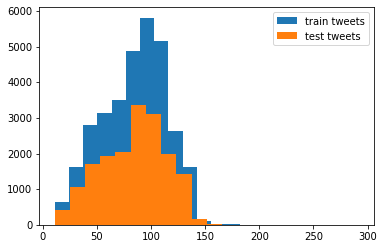

In [13]:
plt.hist(length_train,bins=20,label='train tweets')
plt.hist(length_test,bins=20,label='test tweets')
plt.legend()
plt.show();

In [14]:
#Lets combine train and test set
combi=train.append(test,ignore_index=True)

In [15]:
#function to remove patterns
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    
    return input_txt

In [16]:
#Removing twitter handles. Tweets contain lot of user mentions . It does not provide any information value to us . So let us remove them
#combi['tidy_tweet']=np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')
#combi.head()

In [17]:
#Remove punctuation,special characters and numbers 
#combi['tidy_tweet']=combi['tidy_tweet'].str.replace('[^a-zA-Z#]',' ')
#combi.head()

In [18]:
 #removing short words.Words like hmm,oh don't have much menaing so lets remove short words 
#combi['tidy_tweet']=combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [19]:
#combi['tidy_tweet']

In [20]:
#tokenized_tweet=combi['tidy_tweet'].apply(lambda x:x.split())

In [21]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [22]:
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def tweet_cleaner(text):
    newString=re.sub(r'@[A-Za-z0-9]+','',text)                     #removing user mentions
    newString= ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #contraction mapping
    newString= re.sub(r'http\S+|www.\s+', '', newString)                   #removing links
    newString= re.sub(r"'s\b","",newString)                        #removing 's
    letters_only = re.sub("[^a-zA-Z#]", " ", newString)             #Fetching out only letters and #
    lower_case = letters_only.lower()                              #converting everything to lowercase
    tokens = [w for w in lower_case.split() if len(w)>3 and w not in stop_words ]#stopwords removal
    newString=''
    for i in tokens:                                                 
        newString=newString+lemmatizer.lemmatize(i)+' '            #converting words to lemma                               
    return newString.strip()                               

In [25]:
cleaned_tweets = []
for i in combi.tweet:
    cleaned_tweets.append(tweet_cleaner(i))
print(cleaned_tweets[:5])   #print top 5 records

['father dysfunctional selfish drag kid dysfunction #run', 'thanks #lyft credit cannot cause offer wheelchair van #disapointed #getthanked', 'bihday majesty', '#model love take time', 'factsguide society #motivation']


In [26]:
combi['tidy_tweet']= cleaned_tweets

In [27]:
#Visualizing all word data using wordcloud plot
all_words=''.join([text for text in combi['tidy_tweet']])

In [28]:
from wordcloud import WordCloud

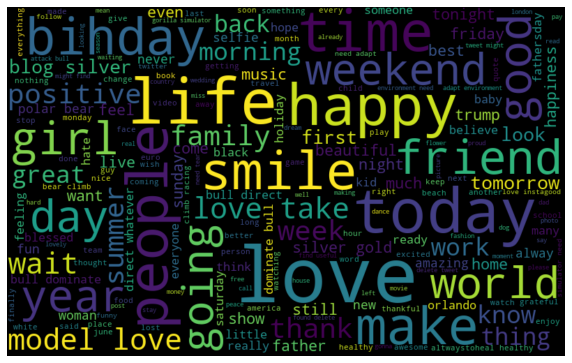

In [29]:
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

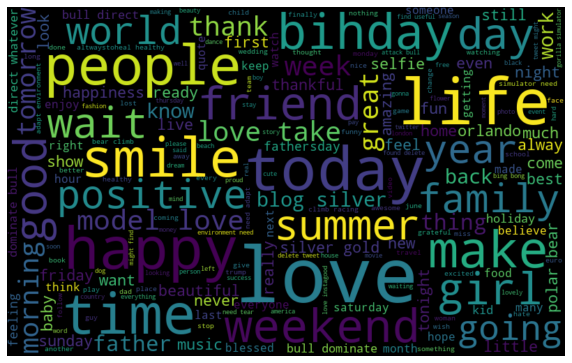

In [30]:
#Words in non-racist/sexist tweets
normal_words=''.join([word for word in combi['tidy_tweet'][combi['label']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

plt.show()

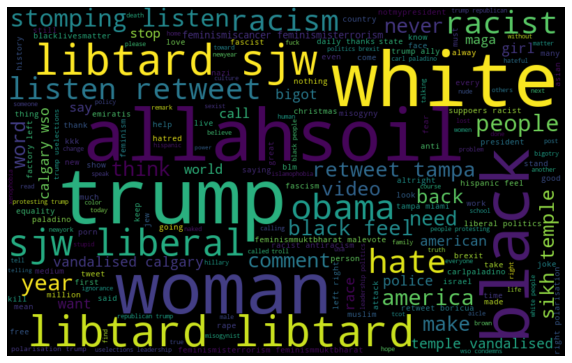

In [31]:
#Words in non-racist/sexist tweets
negative_words=''.join([word for word in combi['tidy_tweet'][combi['label']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Understanding the impact of Hashtags on tweets sentiment


In [32]:
#function to collect hashtags:
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [33]:
#Extracting hashtags from non-racist tweets
HT_regular=hashtag_extract(combi['tidy_tweet'][combi['label']==0])
#Extracting hashtags from racist tweets
HT_negative=hashtag_extract(combi['tidy_tweet'][combi['label']==1])

In [34]:
#unnesting list
HT_regular=sum(HT_regular,[])
HT_negative=sum(HT_negative,[])

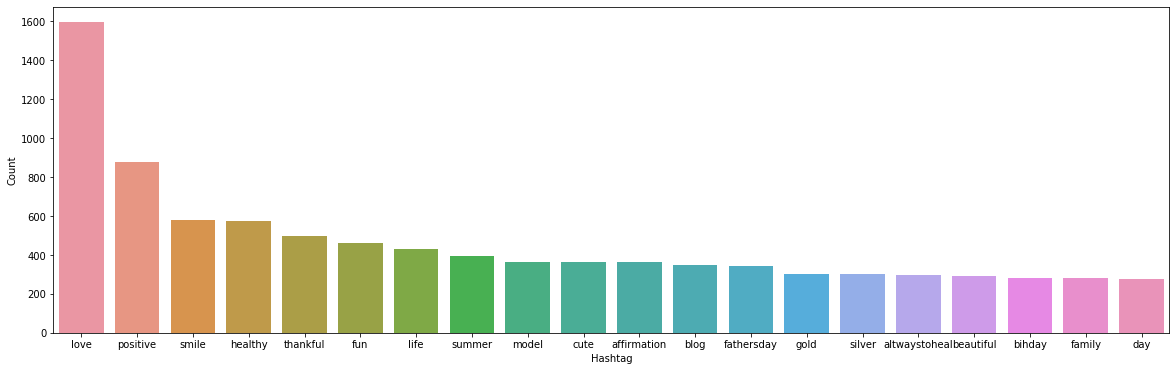

In [35]:
#Finding top 20 words in non racist tweets
a=nltk.FreqDist(HT_regular)
d=pd.DataFrame({'Hashtag':list(a.keys()),'Count':list(a.values())})
d=d.nlargest(columns='Count',n=20)
plt.figure(figsize=(20,6))
ax=sns.barplot(data=d,x="Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

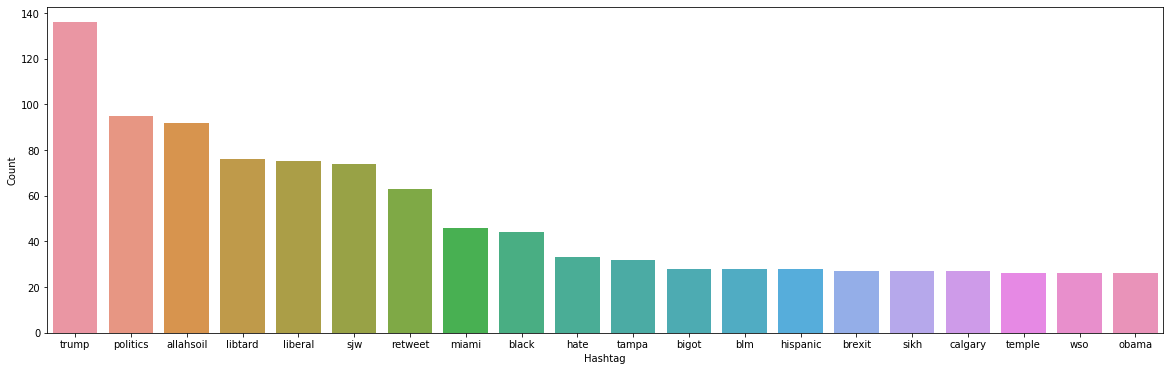

In [36]:
#Finding top 20 words in racist tweets
b=nltk.FreqDist(HT_negative)
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})
e=e.nlargest(columns='Count',n=20)
plt.figure(figsize=(20,6))
ax=sns.barplot(data=e,x="Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

In [37]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cannot cause offer wheelchair van #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [38]:
combi['tweet_len']=combi['tidy_tweet'].str.len()

In [39]:
train=combi[:31962]
test=combi[31962:].reset_index()

In [40]:
train['label']=train['label'].astype('int')

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
test=test.drop('label',axis=1)

In [42]:
train.head()

,id,label,tweet,tidy_tweet,tweet_len
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction #run,54
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cannot cause offer wheelchair van #disapointed #getthanked,78
2,3,0,bihday your majesty,bihday majesty,14
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take time,21
4,5,0,factsguide: society now #motivation,factsguide society #motivation,30


In [43]:
test.head()

,index,id,tweet,tidy_tweet,tweet_len
0,31962,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦,#studiolife #aislife #requires #passion #dedication #willpower find #newmaterials,81
1,31963,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why,#white #supremacists want everyone #birds #movie,48
2,31964,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!,safe way heal #acne #altwaystoheal #healthy #healing,52
3,31965,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite",cursed child book reservation already #harrypotter #pottermore #favorite,72
4,31966,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦",#bihday amazing hilarious #nephew ahmir uncle dave love miss,60


In [44]:
bow_vectorizer=CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')


In [45]:
bow=bow_vectorizer.fit(train['tidy_tweet'])

In [46]:
bow_train=bow_vectorizer.transform(train['tidy_tweet']).toarray()

In [47]:
bow_test=bow_vectorizer.transform(test['tidy_tweet']).toarray()

In [48]:
bow_train=pd.DataFrame(bow_train)

In [49]:
bow_train['length_tweet']=train['tweet_len']
bow_train['label']=train['label']
bow_train.head()

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,78,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,0


In [50]:
bow_test=pd.DataFrame(bow_test)
bow_test['length_tweet']=test['tweet_len']

In [51]:
bow_test.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,length_tweet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,81
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,48
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60


In [52]:
tfidf_vectorizer=TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
tfidf=tfidf_vectorizer.fit(train['tidy_tweet'])

In [53]:
tfidf_train=tfidf_vectorizer.transform(train['tidy_tweet']).toarray()

In [54]:
tfidf_test=tfidf_vectorizer.transform(test['tidy_tweet']).toarray()

In [55]:
tfidf_train=pd.DataFrame(tfidf_train)

In [56]:
tfidf_train['length_tweet']=train['tweet_len']
tfidf_train['label']=train['label']
tfidf_train.head()

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,0


In [57]:
tfidf_train['label']=tfidf_train['label'].astype('int')

In [58]:
tfidf_train.head()

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,0


In [59]:
tfidf_test=pd.DataFrame(tfidf_test)

In [60]:
tfidf_test['length_tweet']=test['tweet_len']
tfidf_test.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,length_tweet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60


In [61]:
tokenized_train=train['tidy_tweet'].apply(lambda x:x.split())
tokenized_test=test['tidy_tweet'].apply(lambda x:x.split())
tokenized_tweet=combi['tidy_tweet'].apply(lambda x:x.split())

In [62]:
import gensim

In [63]:
model_w2v=gensim.models.Word2Vec(tokenized_tweet,window=5,min_count=2,sg=1,hs=0,negative=10,workers=2,seed=34,vector_size=200)

In [64]:
model_w2v.train(tokenized_tweet,total_examples=len(train['tidy_tweet']),epochs=20)

(5810195, 6627900)

In [65]:
model_w2v.wv.most_similar(positive='father')

[('#hackneywick', 0.5751965641975403),
 ('papa', 0.5746424198150635),
 ('kubang', 0.5717471241950989),
 ('#clapton', 0.570738673210144),
 ('#homeon', 0.5700886845588684),
 ('#hackney', 0.5696696639060974),
 ('dad', 0.5686599612236023),
 ('#felizdiadelpadre', 0.5667268633842468),
 ('dadsday', 0.5608843564987183),
 ('#rogergoodell', 0.558236300945282)]

In [66]:
#preparing vector for tweets
def word_vector(tokens,size):
    vec=np.zeros(size).reshape((1,size))
    count=0
    for word in tokens:
        try:
            vec+=model_w2v.wv[word].reshape((1,size))
            count+=1
        except KeyError:
            continue
    if count!=0:
        vec/=count
    return vec
        
        
    

In [67]:
word_vec_arrays=np.zeros((len(tokenized_tweet),200))
for i in range(len(tokenized_tweet)):
    word_vec_arrays[i:]=word_vector(tokenized_tweet[i],200)
    wordvec_df=pd.DataFrame(word_vec_arrays)

In [68]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.100716,-0.064828,-0.138579,-0.083111,-0.335938,0.099729,-0.296350,0.087355,0.371296,-0.172597,...,0.417259,0.003734,-0.317369,-0.283867,0.161349,-0.010402,-0.306125,-0.244576,0.201259,0.076521
1,-0.025604,-0.581314,0.105613,-0.052221,-0.215630,0.214492,-0.190957,0.017356,0.219095,-0.137273,...,0.067744,-0.008499,-0.128722,-0.153719,0.285525,-0.101766,-0.086348,-0.295760,0.188033,0.027758
2,0.030835,-0.053742,0.132948,-0.062377,-0.169658,0.119102,-0.446991,-0.185637,0.600702,0.404885,...,0.031228,-0.464724,0.241534,-0.129301,0.375248,0.063071,-0.774550,0.072469,-0.039450,0.302737
3,0.192795,-0.300758,0.194225,-0.257946,0.115518,-0.112497,-0.543832,0.187165,0.252113,0.233944,...,0.215259,-0.346848,-0.156064,-0.183397,0.783508,0.077387,-0.097663,-0.165056,0.264528,-0.021599
4,-0.114140,-0.531314,0.175050,0.070011,-0.041205,0.213745,-0.031163,-0.148002,0.022318,-0.035381,...,0.323526,-0.148320,-0.248864,-0.028209,-0.050989,-0.008100,0.142014,-0.426876,0.341693,0.172241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.216208,-0.165427,0.427694,0.091027,0.001734,0.511747,0.111052,-0.047459,0.247070,-0.264171,...,0.631295,0.039683,0.214022,-0.254593,0.329188,0.003389,-0.450484,0.297197,0.150292,0.077930
49155,-0.271592,-0.074471,0.054723,-0.237933,0.075943,-0.055871,-0.226855,-0.047375,0.079819,0.009180,...,0.145476,-0.221396,-0.012041,-0.008378,0.242160,0.020558,-0.575779,-0.214673,-0.162279,-0.087933
49156,-0.078908,-0.422972,0.073796,-0.241538,-0.138336,0.123176,-0.149737,0.035554,0.033284,-0.207818,...,0.353650,-0.029471,-0.301735,-0.212746,0.277465,-0.048807,-0.399691,-0.417212,-0.039631,-0.101584
49157,-0.133484,-0.519477,0.027241,0.159100,0.207235,0.059531,0.019713,0.201806,0.580831,-0.243071,...,0.145371,0.060716,0.237734,-0.230838,0.449474,-0.206677,-0.146459,0.042665,-0.122113,0.195887


In [69]:
train_w2v=wordvec_df.iloc[:31962,:]
test_w2v=wordvec_df.iloc[31962:,:]

In [70]:
train_w2v['length_tweet']=train['tweet_len']
train_w2v['label']=train['label']
train_w2v.head()

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,length_tweet,label
0,-0.100716,-0.064828,-0.138579,-0.083111,-0.335938,0.099729,-0.296350,0.087355,0.371296,-0.172597,...,-0.317369,-0.283867,0.161349,-0.010402,-0.306125,-0.244576,0.201259,0.076521,54,0
1,-0.025604,-0.581314,0.105613,-0.052221,-0.215630,0.214492,-0.190957,0.017356,0.219095,-0.137273,...,-0.128722,-0.153719,0.285525,-0.101766,-0.086348,-0.295760,0.188033,0.027758,78,0
2,0.030835,-0.053742,0.132948,-0.062377,-0.169658,0.119102,-0.446991,-0.185637,0.600702,0.404885,...,0.241534,-0.129301,0.375248,0.063071,-0.774550,0.072469,-0.039450,0.302737,14,0
3,0.192795,-0.300758,0.194225,-0.257946,0.115518,-0.112497,-0.543832,0.187165,0.252113,0.233944,...,-0.156064,-0.183397,0.783508,0.077387,-0.097663,-0.165056,0.264528,-0.021599,21,0
4,-0.114140,-0.531314,0.175050,0.070011,-0.041205,0.213745,-0.031163,-0.148002,0.022318,-0.035381,...,-0.248864,-0.028209,-0.050989,-0.008100,0.142014,-0.426876,0.341693,0.172241,30,0


In [71]:
test_w2v['length_tweet']=test['tweet_len']
test_w2v.head()

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,length_tweet
31962,-0.402866,-0.110519,0.132666,0.051850,-0.191141,0.119793,-0.006407,-0.070503,0.316828,-0.119783,...,-0.004452,0.048827,0.222080,0.265974,0.096219,-0.228394,-0.390553,-0.093784,0.056050,NaN
31963,0.146361,-0.212217,0.314408,0.219487,-0.170654,0.351084,-0.206023,-0.060193,0.159610,0.113366,...,-0.315572,-0.145328,-0.123599,0.281128,-0.031157,-0.351120,-0.093399,-0.029449,-0.365143,NaN
31964,-0.107743,0.038953,-0.138308,0.131377,-0.125342,0.156568,-0.008045,-0.030165,0.608625,-0.045038,...,-0.074735,0.177199,0.279184,-0.004516,-0.127639,-0.012323,-0.253962,0.070478,0.242098,NaN
31965,-0.034379,-0.127528,0.230118,-0.071387,-0.042505,0.053210,-0.257815,-0.176700,0.228246,-0.116627,...,-0.044225,0.002367,-0.116430,0.184841,0.220335,0.057945,-0.161313,0.164503,0.000658,NaN
31966,-0.143325,0.048431,-0.035726,-0.148709,-0.208560,-0.043960,-0.317799,-0.138086,0.274424,0.125182,...,-0.290591,-0.081156,-0.189539,0.099692,0.125456,-0.207485,-0.029652,0.213103,0.084753,NaN


### Upsampling BOW

In [72]:
major_class_0,major_class_1=bow_train.label.value_counts()


In [73]:
df_major=bow_train[bow_train['label']==0]
df_minor=bow_train[bow_train['label']==1]

In [74]:
from sklearn.utils import resample

shape (59440, 1002)


C:\Users\91999\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


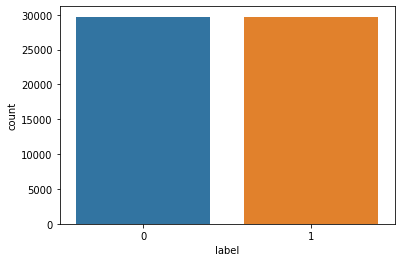

In [75]:
df_minor_upsampled=resample(df_minor,replace=True,n_samples=major_class_0)
df_bow_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_bow_upsampled.shape)
sns.countplot(df_bow_upsampled.label)

shape (59440, 1002)


C:\Users\91999\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


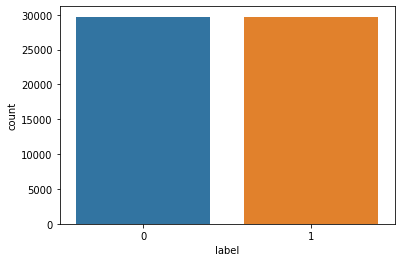

In [76]:
major_class_0,major_class_1=tfidf_train.label.value_counts()
df_major=tfidf_train[tfidf_train['label']==0]
df_minor=tfidf_train[tfidf_train['label']==1]
df_minor_upsampled = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_tfidf_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_tfidf_upsampled.shape)
sns.countplot(df_tfidf_upsampled.label)


shape (59440, 202)


C:\Users\91999\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


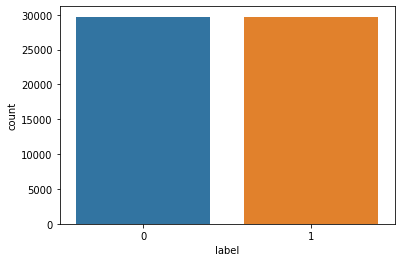

In [77]:
major_class_0,major_class_1=train_w2v.label.value_counts()
df_major=train_w2v[train_w2v['label']==0]
df_minor=train_w2v[train_w2v['label']==1]
df_minor_upsampled = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_w2v_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_w2v_upsampled.shape)
sns.countplot(df_w2v_upsampled.label)


In [78]:
x=df_bow_upsampled.iloc[:,0:-1]
y=df_bow_upsampled['label']
x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(x,y,test_size=0.2)

In [79]:
x=df_tfidf_upsampled.iloc[:,0:-1]
y=df_tfidf_upsampled['label']
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x,y,test_size=0.2)


In [80]:
x=df_w2v_upsampled.iloc[:,0:-1]
y=df_w2v_upsampled['label']
x_train_w2v,x_test_w2v,y_train_w2v,y_test_w2v=train_test_split(x,y,test_size=0.2)


In [81]:
#scoring metric
def f1_score_(y_proba,y_test):
    proba=y_proba[:,1]>=0.3
    proba=proba.astype(np.int)
    return f1_score(proba,y_test)

In [82]:
lreg=LogisticRegression()

In [83]:
lreg.fit(x_train_bow,y_train_bow)

C:\Users\91999\anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\91999\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [84]:
log_pred=lreg.predict_proba(x_test_bow)

C:\Users\91999\anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [85]:
f1_score_(log_pred,y_test_bow)

0.8544987146529563

In [86]:
lreg.fit(x_train_w2v,y_train_w2v)

C:\Users\91999\anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\91999\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [87]:
log_predw=lreg.predict_proba(x_test_w2v)

C:\Users\91999\anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [88]:
f1_score_(log_predw,y_test_w2v)

0.8669896842763363

In [89]:
from xgboost import XGBClassifier

In [90]:
# XGB Word2Vec
xgb_model=XGBClassifier(max_depth=6,n_estimators=1000).fit(x_train_w2v,y_train_w2v)
xg_pred=xgb_model.predict(x_test_w2v)
f1_score_(xg_pred,y_test_w2v)

C:\Users\91999\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
f1_score(y_test_w2v,xg_pred)

In [ ]:
final_pred=xgb_model.predict(test_w2v)

In [ ]:
test['label']=final_pred

In [ ]:
test.head()

In [ ]:
test.info()

In [ ]:
test['label'].astype('int')

In [ ]:
submission=test[['id','label']]

In [ ]:
submission.head()

In [ ]:
submission.to_csv('sub_xgb_upsample.csv',index=False)

In [ ]:
submission['label'].value_counts()

In [ ]:
prediction_int = log_predw[:,1]>=0.3

In [ ]:
prediction_int=prediction_int.astype(np.int)

In [ ]:
f1_score(y_test_w2v,prediction_int)

In [ ]:
test_w2v